In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Project Started!")

df = pd.read_csv('Phishing_Legitimate_full.csv')

print(f"Total URLs: {df.shape[0]}")
print("Columns:", df.columns.tolist())
print("\nLabel distribution:")
print(df['CLASS_LABEL'].value_counts())   # 1 = Phishing, 0 = Legitimate

df.head()

Project Started!
Total URLs: 10000
Columns: ['id', 'NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore', 'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash', 'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress', 'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname', 'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath', 'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks', 'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms', 'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction', 'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch', 'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow', 'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle', 'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT', 'PctExtNullSelfRedirectHyperlinksRT', 'CLASS_LABEL']

Label distribution:
CLASS_LABEL
1  

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


In [2]:
def extract_features(url):
    f = {}
    f['length'] = len(url)
    f['dots'] = url.count('.')
    f['slashes'] = url.count('/')
    f['at'] = 1 if '@' in url else 0
    f['ip'] = 1 if re.search(r'\d+\.\d+\.\d+\.\d+', url) else 0
    domain = url.split('//')[-1].split('/')[0]
    f['subdomains'] = len(domain.split('.')) - 1
    suspicious = ['login','secure','update','bank','verify','paypal','account','free','password']
    f['suspicious_word'] = 1 if any(w in url.lower() for w in suspicious) else 0
    f['https'] = 1 if url.startswith('https') else 0
    f['question_mark'] = url.count('?')
    f['hyphen'] = url.count('-')
    f['digits'] = sum(c.isdigit() for c in url)  # BONUS feature
    return f

print("Feature function ready!")

Feature function ready!


In [3]:

X = df.drop(['id', 'CLASS_LABEL'], axis=1)
y = df['CLASS_LABEL']

print(f"\nTotal features used: {X.shape[1]} (All expert-engineered)")
print("Features include: NumDots, UrlLength, NoHttps, AtSymbol, NumDash, IpAddress, etc.")


print(f"\nX shape: {X.shape}")
print("y shape:", y.shape)

X.head()


Total features used: 48 (All expert-engineered)
Features include: NumDots, UrlLength, NoHttps, AtSymbol, NumDash, IpAddress, etc.

X shape: (10000, 48)
y shape: (10000,)


,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,...,SubmitInfoToEmail,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT
0,3,1,5,72,0,0,0,0,0,0,...,0,0,0,1,1,0,1,1,-1,1
1,3,1,3,144,0,0,0,0,2,0,...,0,0,0,0,1,-1,1,1,1,1
2,3,1,2,58,0,0,0,0,0,0,...,0,0,0,0,1,0,-1,1,-1,0
3,3,1,6,79,1,0,0,0,0,0,...,1,0,0,0,1,-1,1,1,1,-1
4,3,0,4,46,0,0,0,0,0,0,...,0,1,0,0,1,1,-1,0,-1,-1


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 8000
Testing samples: 2000


In [5]:
print("Training Naive Bayes...")
nb = GaussianNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)

print("Training Decision Tree...")
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)

print("Both models trained successfully!")


Training Naive Bayes...
Training Decision Tree...
Both models trained successfully!


               FINAL RESULTS              
Naive Bayes  →  85.85%
Decision Tree →  96.40%
------------------------------------------------------------
WINNER → Decision Tree with 96.40% accuracy!


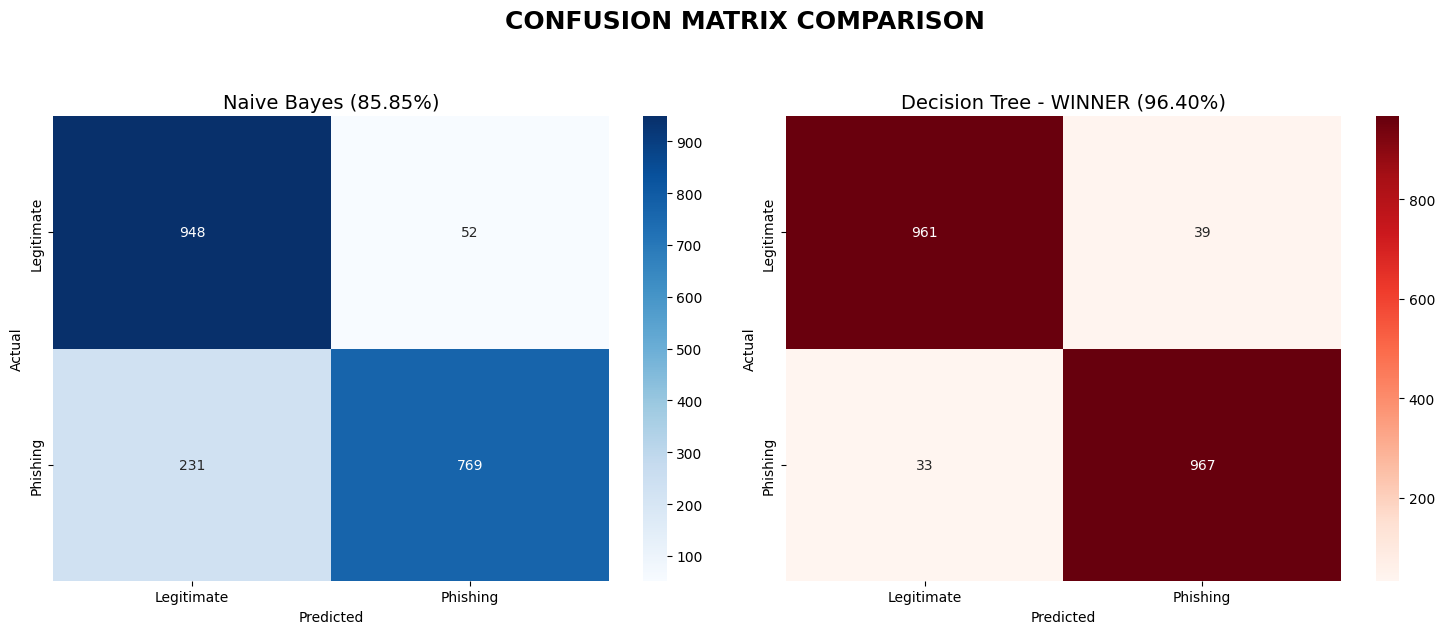


Best model saved → 'phishing_model_final.pkl'


In [6]:


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("="*60)
print("               FINAL RESULTS              ")
print("="*60)


nb_accuracy = accuracy_score(y_test, pred_nb) * 100
dt_accuracy = accuracy_score(y_test, pred_dt) * 100

print(f"Naive Bayes  →  {nb_accuracy:.2f}%")
print(f"Decision Tree →  {dt_accuracy:.2f}%")
print("-"*60)


if dt_accuracy > nb_accuracy:
    print(f"WINNER → Decision Tree with {dt_accuracy:.2f}% accuracy!")
    best_model = dt
else:
    print(f"WINNER → Naive Bayes with {nb_accuracy:.2f}% accuracy!")
    best_model = nb

print("="*60)

# Beautiful Confusion Matrix
plt.figure(figsize=(15,6))
plt.suptitle("CONFUSION MATRIX COMPARISON", fontsize=18, fontweight='bold', y=1.05)

# Naive Bayes
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, pred_nb), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.title(f'Naive Bayes ({nb_accuracy:.2f}%)', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Decision Tree
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, pred_dt), annot=True, fmt='d', cmap='Reds',
            xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.title(f'Decision Tree - WINNER ({dt_accuracy:.2f}%)', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Save best model
joblib.dump(best_model, 'phishing_model_final.pkl')
print("\nBest model saved → 'phishing_model_final.pkl'")


In [7]:

print(f"Best Accuracy Achieved: {max(nb_accuracy, dt_accuracy):.2f}%")
print("Model saved → phishing_model_final.pkl")
print("Dataset: Phishing_Legitimate_full.csv (49 expert features)")
print("Approach: Supervised Learning using Decision Tree & Naive Bayes")


Best Accuracy Achieved: 96.40%
Model saved → phishing_model_final.pkl
Dataset: Phishing_Legitimate_full.csv (49 expert features)
Approach: Supervised Learning using Decision Tree & Naive Bayes


In [8]:

df = pd.read_csv('Phishing_Legitimate_full.csv')
new_features_list = [
    'NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
    'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
    'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
    'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
    'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname',
    'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath',
    'NumSensitiveWords', 'EmbeddedBrandName', 'SubdomainLevelRT', 'UrlLengthRT'
]


X_new = df[new_features_list]
y = df['CLASS_LABEL']


X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)


new_dt_model = DecisionTreeClassifier(random_state=42)
new_dt_model.fit(X_train, y_train)


import joblib
joblib.dump(new_dt_model, 'phishing_model_v2.pkl')

print("Naya Model v2 is Ready! ")

Naya Model v2 is Ready! 


Using existing model: DecisionTreeClassifier


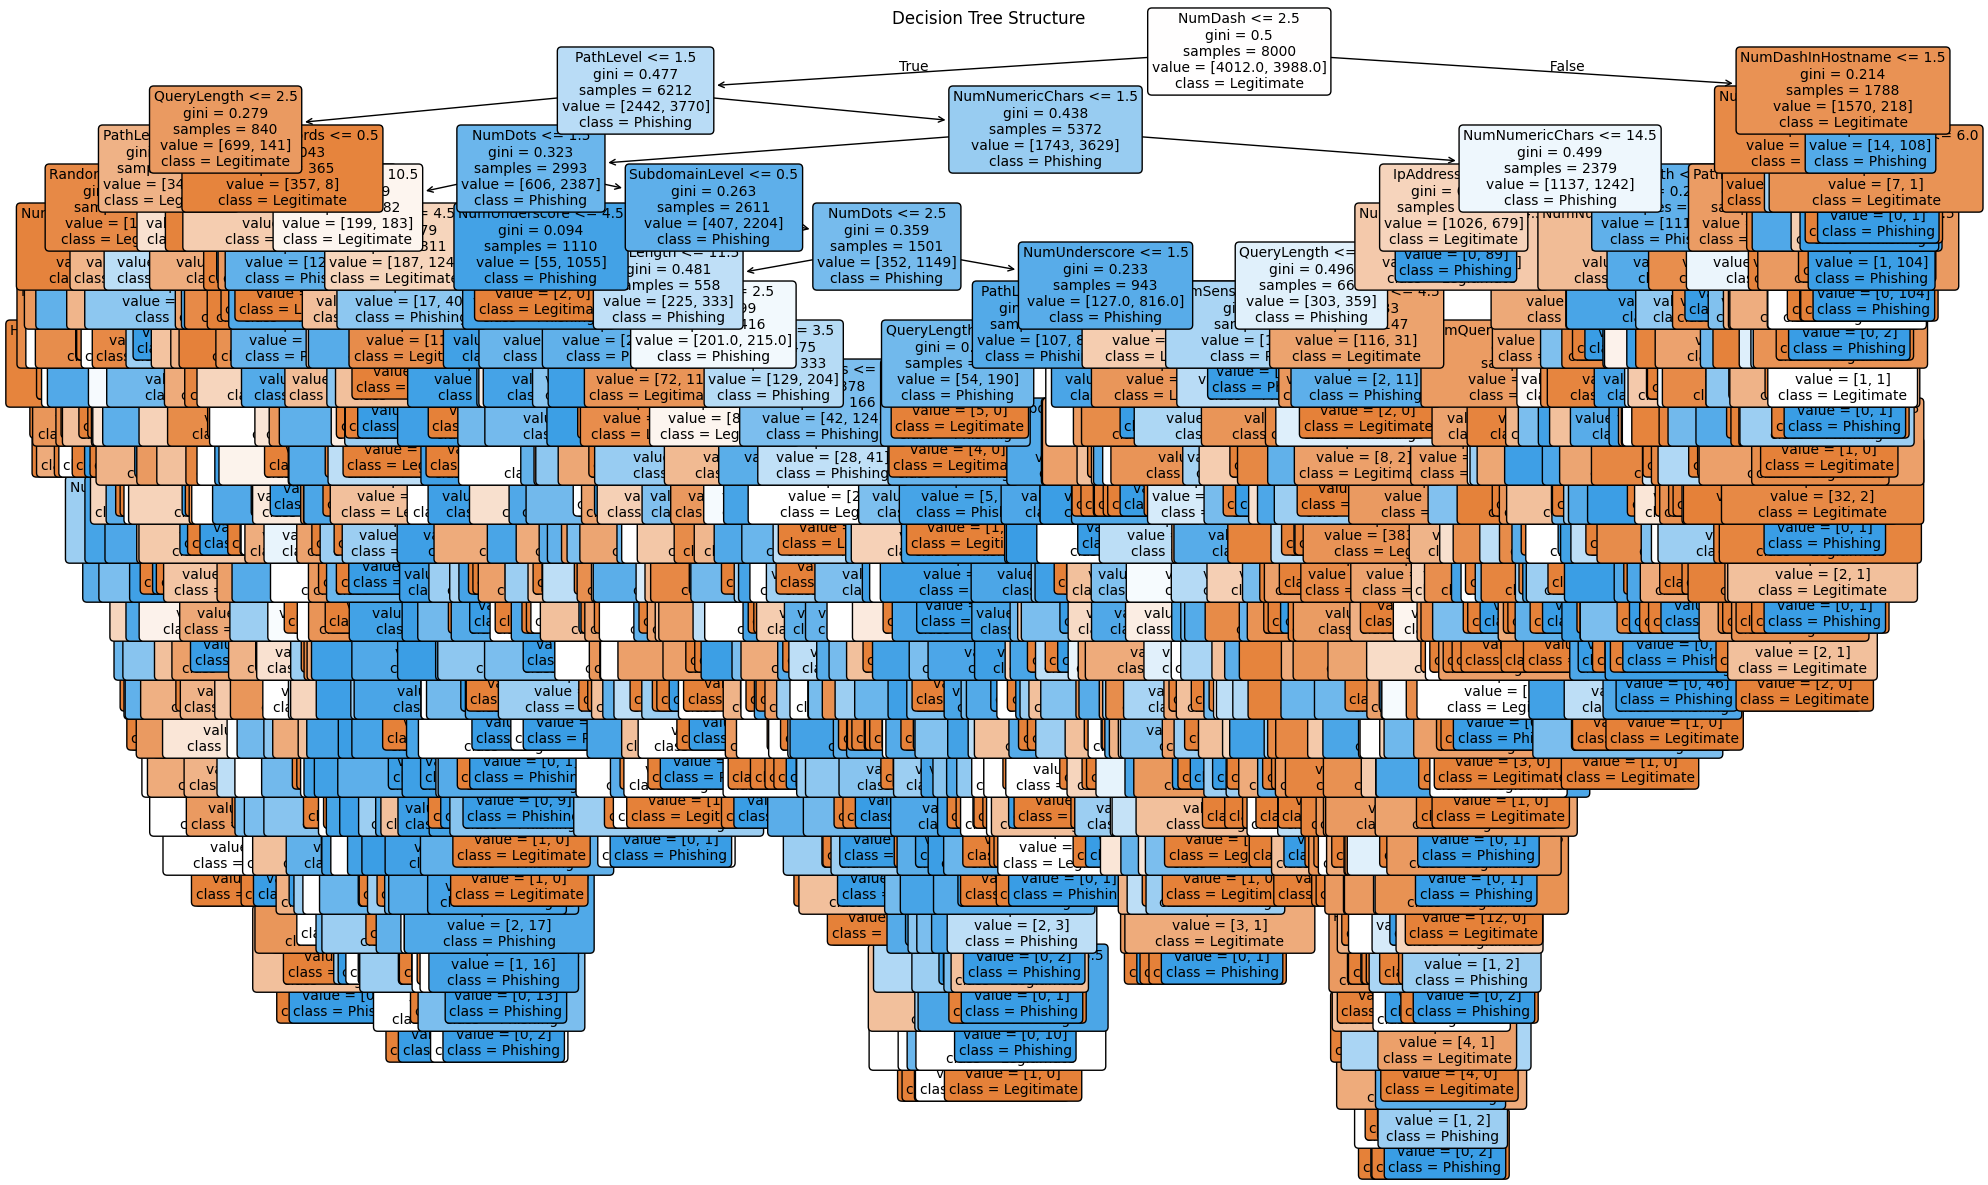

Saved decision tree image to: decision_tree_structure.png


In [9]:
# Decision Tree structure visualization
# This cell will use `new_dt_model`, `dt`, or `best_model` if available.
# Otherwise it will train a fresh DecisionTreeClassifier on `X_new` (or `X`) and `y`.
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

model = globals().get('new_dt_model') or globals().get('dt') or globals().get('best_model')

if model is None:
    if 'X_new' in globals() and 'y' in globals():
        print("No existing Decision Tree model found — training on `X_new` and `y`...")
        model = DecisionTreeClassifier(random_state=42)
        model.fit(X_new, y)
    elif 'X' in globals() and 'y' in globals():
        print("No existing Decision Tree model found — training on `X` and `y`...")
        model = DecisionTreeClassifier(random_state=42)
        model.fit(X, y)
    else:
        raise RuntimeError("No Decision Tree model or dataset (`X_new`/`X` and `y`) available. Run earlier cells first.")
else:
    print(f"Using existing model: {model.__class__.__name__}")

# Determine feature names if available
feature_names = None
if 'X_new' in globals() and hasattr(X_new, 'columns'):
    feature_names = list(X_new.columns)
elif 'X' in globals() and hasattr(X, 'columns'):
    feature_names = list(X.columns)

fig = plt.figure(figsize=(20, 12))
_ = tree.plot_tree(model,
                   feature_names=feature_names,
                   class_names=['Legitimate', 'Phishing'],
                   filled=True,
                   rounded=True,
                   fontsize=10)
plt.title('Decision Tree Structure')
plt.tight_layout()
outfile = 'decision_tree_structure.png'
fig.savefig(outfile, dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved decision tree image to: {outfile}")

In [10]:
# Print root node information and compute information gain per feature
# Uses existing Decision Tree (new_dt_model, dt, best_model) or trains one if needed.
from sklearn.tree import DecisionTreeClassifier

model = globals().get('new_dt_model') or globals().get('dt') or globals().get('best_model')

# Ensure feature_names are available
feature_names = None
if 'X_new' in globals() and hasattr(X_new, 'columns'):
    feature_names = list(X_new.columns)
elif 'X' in globals() and hasattr(X, 'columns'):
    feature_names = list(X.columns)

if model is None:
    if 'X_new' in globals() and 'y' in globals():
        print("Training Decision Tree on `X_new` and `y` to compute info gains...")
        model = DecisionTreeClassifier(random_state=42)
        model.fit(X_new, y)
    elif 'X' in globals() and 'y' in globals():
        print("Training Decision Tree on `X` and `y` to compute info gains...")
        model = DecisionTreeClassifier(random_state=42)
        model.fit(X, y)
    else:
        raise RuntimeError("No Decision Tree model or dataset (`X_new`/`X` and `y`) available. Run earlier cells first.")

# Access underlying tree
tree_ = model.tree_
feature = tree_.feature
impurity = tree_.impurity
n_node_samples = tree_.n_node_samples
children_left = tree_.children_left
children_right = tree_.children_right
thresholds = tree_.threshold
values = tree_.value

# Root node info (node index 0)
root_idx = 0
root_feat_idx = feature[root_idx]
if root_feat_idx >= 0:
    root_feat_name = feature_names[root_feat_idx] if feature_names is not None else f"feature_{root_feat_idx}"
    print(f"Root node (index {root_idx}): splits on feature '{root_feat_name}' (index {root_feat_idx})")
    print(f"  threshold = {thresholds[root_idx]:.6f}")
else:
    print("Root node is a leaf (no split).")
print(f"Root impurity = {impurity[root_idx]:.6f}, samples = {int(n_node_samples[root_idx])}")
if values is not None:
    class_counts = values[root_idx][0] if values.shape[1] > 0 else values[root_idx]
    print(f"Root class distribution (counts): {list(map(int, class_counts))}")

# Compute information gain per feature (weighted by number of samples at each split)
feature_weighted_gain = {}
for node in range(tree_.node_count):
    f = feature[node]
    if f >= 0:
        left = children_left[node]
        right = children_right[node]
        n_left = n_node_samples[left]
        n_right = n_node_samples[right]
        n_node = n_node_samples[node]
        # impurity decrease at this node (per-sample)
        impurity_decrease = impurity[node] - (n_left * impurity[left] + n_right * impurity[right]) / n_node
        # weighted gain (total decrease summed across samples)
        weighted_gain = impurity_decrease * n_node
        name = feature_names[f] if feature_names is not None else f"feature_{f}"
        feature_weighted_gain[name] = feature_weighted_gain.get(name, 0.0) + weighted_gain

# Display results
total_weighted = sum(feature_weighted_gain.values())
print('\nInformation gain (weighted) per feature:')
if total_weighted == 0 or len(feature_weighted_gain) == 0:
    print("  No splits found or zero total gain (tree might be a stump).")
else:
    for name, wg in sorted(feature_weighted_gain.items(), key=lambda x: x[1], reverse=True):
        pct = (wg / total_weighted * 100) if total_weighted > 0 else 0.0
        print(f"- {name}: weighted_gain={wg:.6f}, relative_importance={pct:.2f}%")

# Also show sklearn's normalized feature_importances_ if available
if hasattr(model, 'feature_importances_'):
    print('\nSklearn `feature_importances_` (normalized):')
    importances = model.feature_importances_
    if feature_names is not None:
        for name, imp in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
            print(f"- {name}: {imp:.6f}")
    else:
        print(importances)


Root node (index 0): splits on feature 'NumDash' (index 4)
  threshold = 2.500000
Root impurity = 0.499996, samples = 8000
Root class distribution (counts): [0, 0]

Information gain (weighted) per feature:
- NumDash: weighted_gain=743.827447, relative_importance=18.69%
- NumNumericChars: weighted_gain=596.135055, relative_importance=14.98%
- PathLevel: weighted_gain=575.095206, relative_importance=14.45%
- PathLength: weighted_gain=445.060739, relative_importance=11.19%
- NumDots: weighted_gain=237.077889, relative_importance=5.96%
- UrlLength: weighted_gain=236.947145, relative_importance=5.96%
- HostnameLength: weighted_gain=219.571765, relative_importance=5.52%
- NumDashInHostname: weighted_gain=183.369884, relative_importance=4.61%
- QueryLength: weighted_gain=147.602298, relative_importance=3.71%
- NumUnderscore: weighted_gain=95.445357, relative_importance=2.40%
- SubdomainLevel: weighted_gain=93.899609, relative_importance=2.36%
- NumSensitiveWords: weighted_gain=82.836597, rela

Running GridSearchCV (DecisionTree) — this may take a minute...
GridSearch best params: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5}
GridSearch best CV f1: 0.8710745680767424
Saved GridSearch model to phishing_dt_gs.pkl

Computing cost-complexity pruning path (ccp_alpha) and evaluating via CV...
Best ccp_alpha: 0.00024107142857142855 with CV f1: 0.8778237968015687


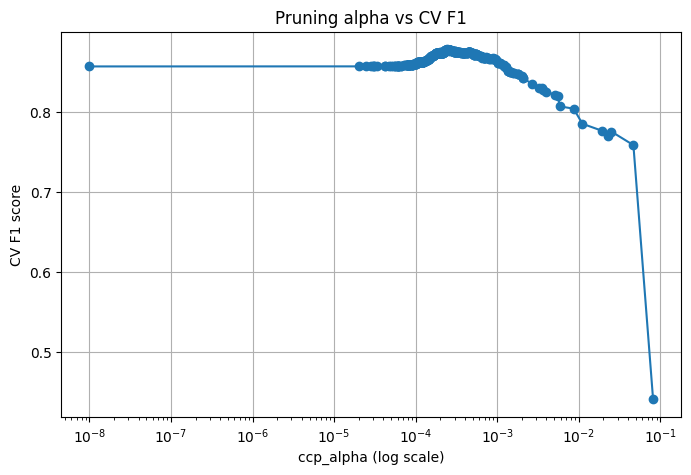

Saved plot to ccp_alpha_vs_score.png
Saved pruned model to phishing_dt_pruned.pkl


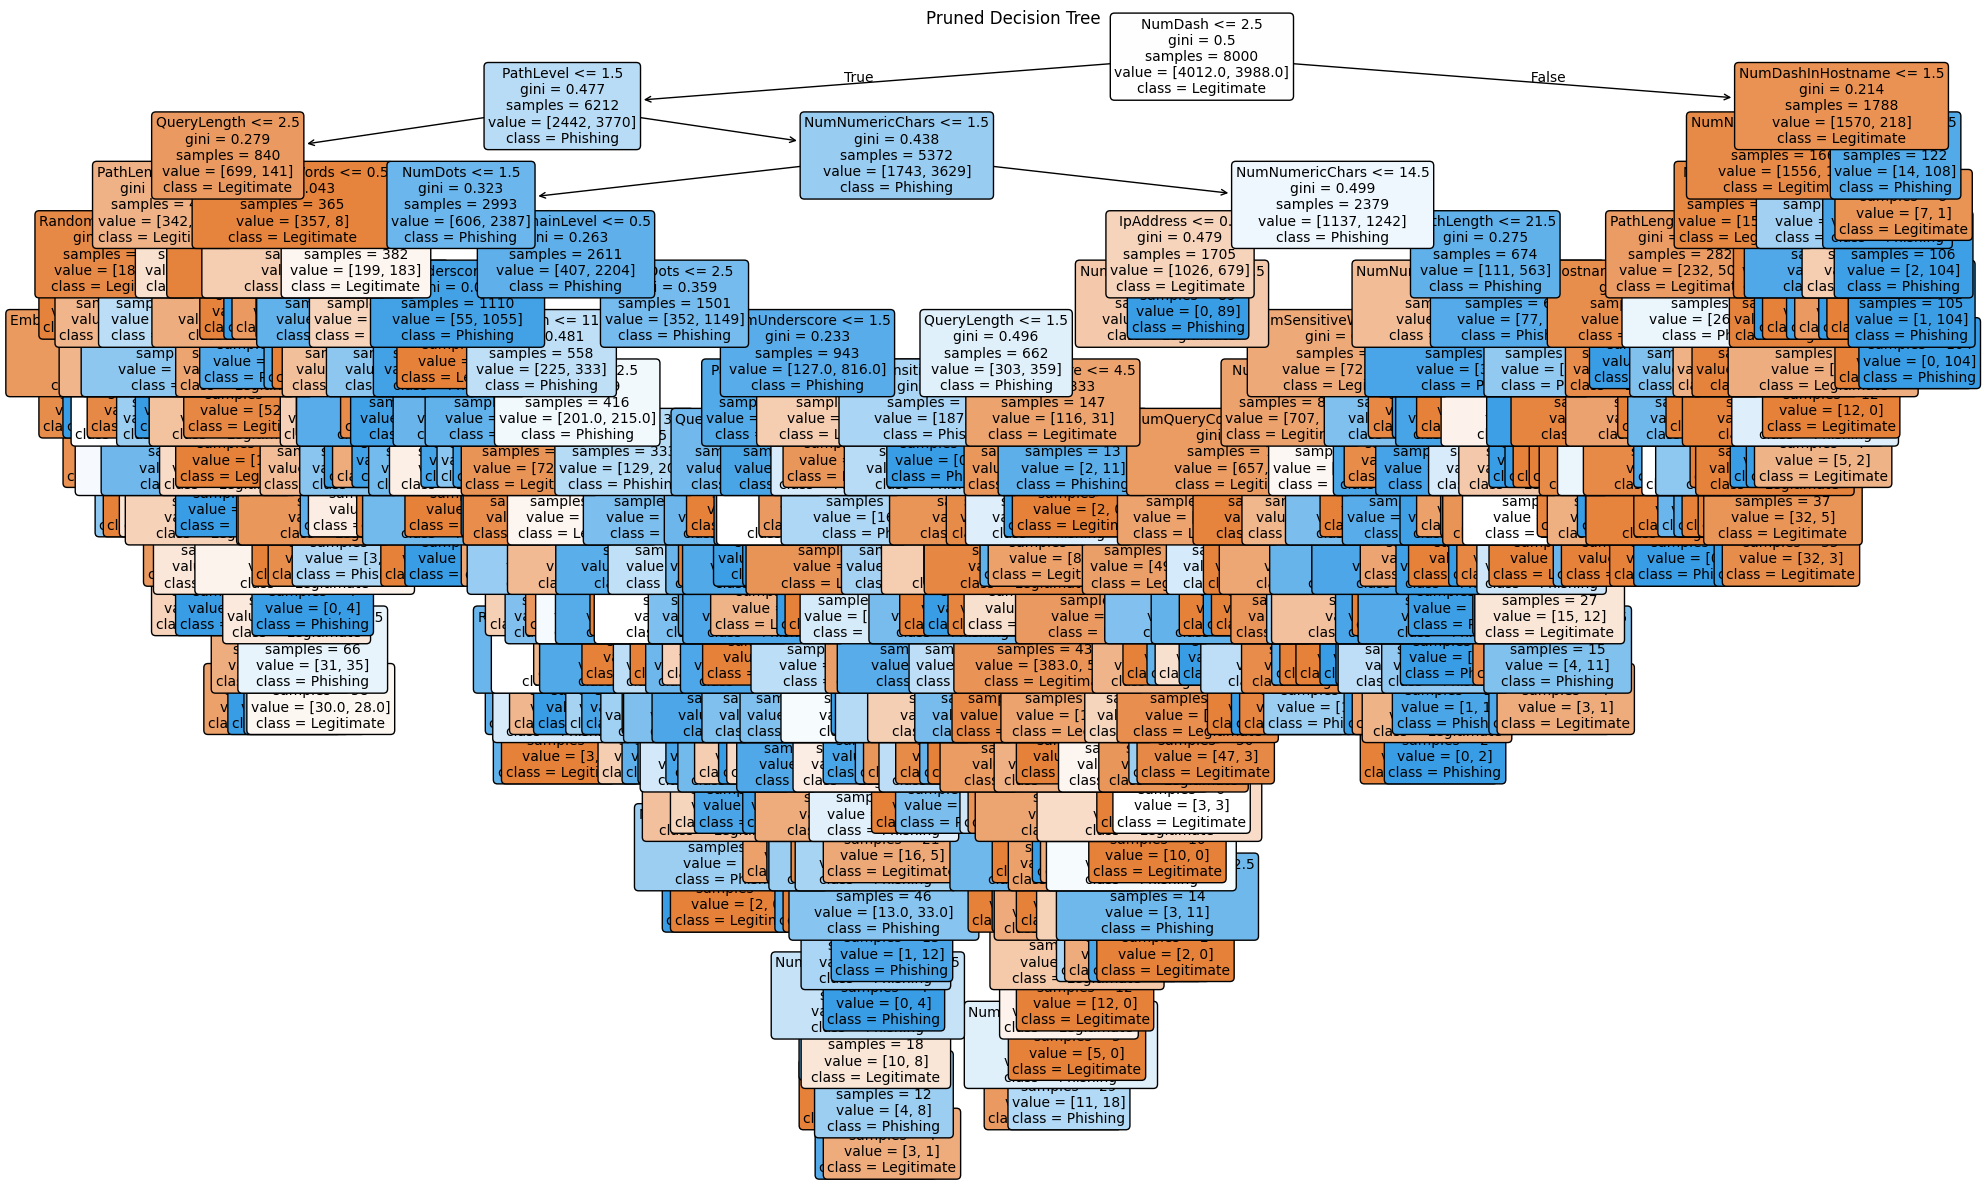

Saved pruned tree image to decision_tree_pruned.png


In [11]:
# Decision Tree hyperparameter tuning (GridSearchCV) + cost-complexity pruning
# - Runs GridSearchCV on DecisionTree (only algorithms you've learned)
# - Evaluates pruning path and selects best ccp_alpha by CV
# - Saves models and plots
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Select training data (fall back to X_new/X if needed)
if 'X_train' in globals() and 'y_train' in globals():
    Xt, yt = X_train, y_train
elif 'X_new' in globals() and 'y' in globals():
    from sklearn.model_selection import train_test_split
    Xt, _, yt, _ = train_test_split(X_new, y, test_size=0.2, random_state=42, stratify=y)
elif 'X' in globals() and 'y' in globals():
    from sklearn.model_selection import train_test_split
    Xt, _, yt, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
else:
    raise RuntimeError("No training data found. Run earlier cells to create `X_train`/`y_train` or `X_new`/`y`.")

# Feature names for plotting trees
if 'X_new' in globals() and hasattr(X_new, 'columns'):
    feature_names = list(X_new.columns)
elif 'X' in globals() and hasattr(X, 'columns'):
    feature_names = list(X.columns)
else:
    feature_names = None

print('Running GridSearchCV (DecisionTree) — this may take a minute...')
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 5, 10],
    'class_weight': [None, 'balanced']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=cv, scoring='f1', n_jobs=-1)
gs.fit(Xt, yt)
print('GridSearch best params:', gs.best_params_)
print('GridSearch best CV f1:', gs.best_score_)

best_dt = gs.best_estimator_
joblib.dump(best_dt, 'phishing_dt_gs.pkl')
print('Saved GridSearch model to phishing_dt_gs.pkl')

# Cost-complexity pruning path (use fresh estimator trained on training set)
print('\nComputing cost-complexity pruning path (ccp_alpha) and evaluating via CV...')
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(Xt, yt)
ccp_alphas = np.unique(path.ccp_alphas)

alpha_scores = []
for a in ccp_alphas:
    clf_a = DecisionTreeClassifier(random_state=42, ccp_alpha=a)
    scores = cross_val_score(clf_a, Xt, yt, cv=cv, scoring='f1', n_jobs=-1)
    alpha_scores.append(scores.mean())

alpha_scores = np.array(alpha_scores)
best_idx = np.nanargmax(alpha_scores)
best_alpha = ccp_alphas[best_idx]
print('Best ccp_alpha:', best_alpha, 'with CV f1:', alpha_scores[best_idx])

# Plot alpha vs CV score
plt.figure(figsize=(8,5))
# avoid zeros on log scale: shift small values
plot_alphas = np.maximum(ccp_alphas, 1e-8)
plt.plot(plot_alphas, alpha_scores, marker='o')
plt.xscale('log')
plt.xlabel('ccp_alpha (log scale)')
plt.ylabel('CV F1 score')
plt.title('Pruning alpha vs CV F1')
plt.grid(True)
plt.savefig('ccp_alpha_vs_score.png', bbox_inches='tight', dpi=150)
plt.show()
print('Saved plot to ccp_alpha_vs_score.png')

# Train final pruned tree with best_alpha on full training set and save
pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=float(best_alpha))
pruned.fit(Xt, yt)
joblib.dump(pruned, 'phishing_dt_pruned.pkl')
print('Saved pruned model to phishing_dt_pruned.pkl')

# Save a visualization of the pruned tree
plt.figure(figsize=(20,12))
_ = tree.plot_tree(pruned,
                   feature_names=feature_names,
                   class_names=['Legitimate', 'Phishing'],
                   filled=True,
                   rounded=True,
                   fontsize=10)
plt.title('Pruned Decision Tree')
plt.tight_layout()
plt.savefig('decision_tree_pruned.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved pruned tree image to decision_tree_pruned.png')